In [1]:
import json
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pymystem3 import Mystem


In [4]:
from nltk.corpus import stopwords

In [5]:
from tqdm import tqdm_notebook

In [6]:
comments = json.load(open('out.json'))

In [7]:
comments_df = pd.DataFrame(comments)

In [8]:
comments_df["comment"] = comments_df["comment"].str.strip()

In [9]:
comments_df["url"].nunique()

8033

In [10]:
def parse_meta(meta):
    meta_dict = {}
    for pair in str(meta).split(","):
        if "=" in pair:
            key, value = pair.split("=")
            meta_dict[key] = value
    return meta_dict

comments_df["meta"] = comments_df["meta"].apply(parse_meta)

In [11]:
comments_df["id"] = comments_df["meta"].apply(lambda x: x.get("id"))

In [12]:
comments_df["pid"] = comments_df["meta"].apply(lambda x: x.get("pid"))

In [13]:
comments_df["time"] = pd.to_datetime(comments_df["meta"].apply(lambda x: x.get("d")))

In [14]:
comments_df["likes"] = pd.to_numeric(comments_df["rating"].apply(lambda x: x.split(",")[0].split(" ")[0].strip()), errors='coerce')

In [15]:
comments_df["dislikes"] = pd.to_numeric(comments_df["rating"].apply(lambda x: x.split(",")[-1].strip().split(" ")[0].strip()), errors='coerce')

In [16]:
import re
cleanr = re.compile('<.*?>')
linksr = re.compile("<a .+>.+</a>")

def cleanhtml(raw_html):
    raw_html = raw_html.replace("<br>", "\n")
    cleantext = re.sub(linksr, ' ', raw_html)
    cleantext = re.sub(cleanr, ' ', cleantext)
    return cleantext

In [17]:
comments_df["cleaned_post"] = [cleanhtml(post) for post in tqdm_notebook(comments_df["comment"])]

In [18]:
comments_df["cleaned_post"] = comments_df["cleaned_post"].str.strip()

# Normalize + lemmatize

In [19]:
import sys
sys.path.append("../../")

In [21]:
from preprocess.preprocess import preprocess_text

In [22]:
comments_df["normalized_post"] = [preprocess_text(post) for post in tqdm_notebook(comments_df["cleaned_post"])]

In [23]:
comments_df.to_csv("prepared_dataset.csv")

Normalize + lemmatize posts

In [28]:
posts = json.load(open('posts.json'))

In [29]:
posts_df = pd.DataFrame(posts)

In [30]:
posts_df["text"] = posts_df["tags"].apply(lambda x: ", ".join(x)) + ". " + posts_df["title"]

In [31]:
posts_lemmatized = [lemmatize_text(normalize_post(post)) for post in tqdm_notebook(posts_df["text"])]

In [32]:
posts_df["lemmas"] = posts_lemmatized

In [33]:
posts_df.to_csv("prepared_posts_dataset.csv")

# Learn word2vec representations

In [7]:
from gensim.models.word2vec import Word2Vec

In [6]:
comments_df = pd.read_csv("prepared_dataset.csv")

In [18]:
texts = comments_df["normalized_post"].tolist()

In [20]:
texts_preprocessed = [[word for word in str(text).split()] for text in tqdm_notebook(texts)]

In [21]:
texts_preprocessed = [text for text in texts_preprocessed if len(text)]

In [22]:
model = Word2Vec(texts_preprocessed, size=50, window=10, min_count=1, workers=3, iter=10)

In [25]:
model.save("50features_1minwords_10context")

# Find topics

- Remove stopwords and rare words
- Remove short texts
- Find topics
- Match contrary and similar topics

In [196]:
from collections import Counter
import numpy as np
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
import random

In [87]:
rus_stopwords = set(stopwords.words("russian"))

In [88]:
texts = comments_df["lemmas"].apply(lambda x: x.split(" ")).tolist()

In [89]:
texts += posts_df["lemmas"].apply(lambda x: x.split(" ")).tolist()

In [90]:
texts = [[word for word in text if word and (word.split("_")[0] not in rus_stopwords)] for text in tqdm_notebook(texts)]

In [91]:
all_words = [word for text in texts for word in text]
frequencies = dict(Counter(all_words).most_common())

In [92]:
rare_threshold = np.percentile(list(frequencies.values()), 70)
rare_words = set([word for word in frequencies if frequencies[word] < rare_threshold])

In [93]:
texts = [[word for word in text if (word not in rare_words)] for text in tqdm_notebook(texts)]

In [110]:
texts = [text for text in texts if len(text) > 5]

In [112]:
dictionary = Dictionary(texts)

In [113]:
bow_texts = [dictionary.doc2bow(text) for text in tqdm_notebook(texts)]

In [160]:
w2v = api.load("word2vec-ruscorpora-300") 

In [181]:
text_vectors = []
for index, text in enumerate(tqdm_notebook(texts)):
    vectors = [w2v.word_vec(word) for word in text if word in w2v.vocab]
    if vectors:
        text_vector = np.median(vectors, axis=0)
        text_vectors.append(text_vector)

In [182]:
text_vectors = np.array(text_vectors)

In [183]:
svd = TruncatedSVD(n_components=2)
svd_vectors = svd.fit_transform(text_vectors)

In [ ]:
plt.figure(figsize=(100, 100))
plt.scatter(svd_vectors.T[0], svd_vectors.T[1], s=0.1)

selected_texts = [random.choice(texts) for _ in range(1000)]

for index, words in enumerate(selected_texts):
    x, y = svd_vectors[index]
    text = " ".join([word.split("_")[0] for word in words[0:5]])
    plt.text(x, y, text, fontdict={"size": 10})

# Find most toxic topics by tags

In [22]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import scipy.sparse as sps
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns

In [21]:
posts = json.load(open('posts.json'))

In [311]:
counter = Counter([tag for post in posts for tag in post["tags"]])
tags = {word: index for index, word in enumerate([word for word, count in counter.most_common(500) if count < 100])}

In [322]:
rows = []
columns = []

for post in posts:
    for tag in post["tags"]:
        if tag not in tags:
            continue
        for neighbour_tag in post["tags"]:
            if neighbour_tag not in tags:
                continue
            if tag != neighbour_tag:
                tag_index = tags[tag]
                neighbour_tag_index = tags[neighbour_tag]
                rows.append(tag_index)
                columns.append(neighbour_tag_index)

In [323]:
data = np.ones(len(rows))

In [324]:
tags_matrix = sps.coo_matrix((data, (rows, columns)), shape=(len(tags), len(tags))).todense()

In [325]:
svd = TruncatedSVD(n_components=2)
tsne = TSNE(n_jobs=4)

In [368]:
tags_matrix.shape

(454, 454)

In [369]:
svd_tags_matrix = tsne.fit_transform(tags_matrix)

In [370]:
url_to_index = {post["url"]: index for index, post in enumerate(posts)}

In [371]:
negative_df = comments_df.groupby("url").negative.sum() / comments_df.groupby("url").size()

In [372]:
negative_indices = [url_to_index.get(url) for url in negative_df[negative_df > 0.1].index if url_to_index.get(url)]

Like/dislike proportion for each tag

In [373]:
tags_shares = {}
for tag in tqdm_notebook(tags):
    urls = [post["url"] for post in posts if tag in post["tags"]]
    selected_posts = comments_df[(comments_df["url"].isin(urls)) & ((comments_df["likes"] + comments_df["dislikes"]) > 10)]
    shares = selected_posts["dislikes"] / (selected_posts["likes"] + selected_posts["dislikes"])
    tags_shares[tag] = shares.tolist()

Visualize result

In [388]:
disliked_indices = []
for tag in tags_shares:
    for share, _ in zip(tags_shares[tag], range(400)):
        if share > 0.9:
            disliked_indices.append(tags[tag])

In [389]:
len(disliked_indices)

3273

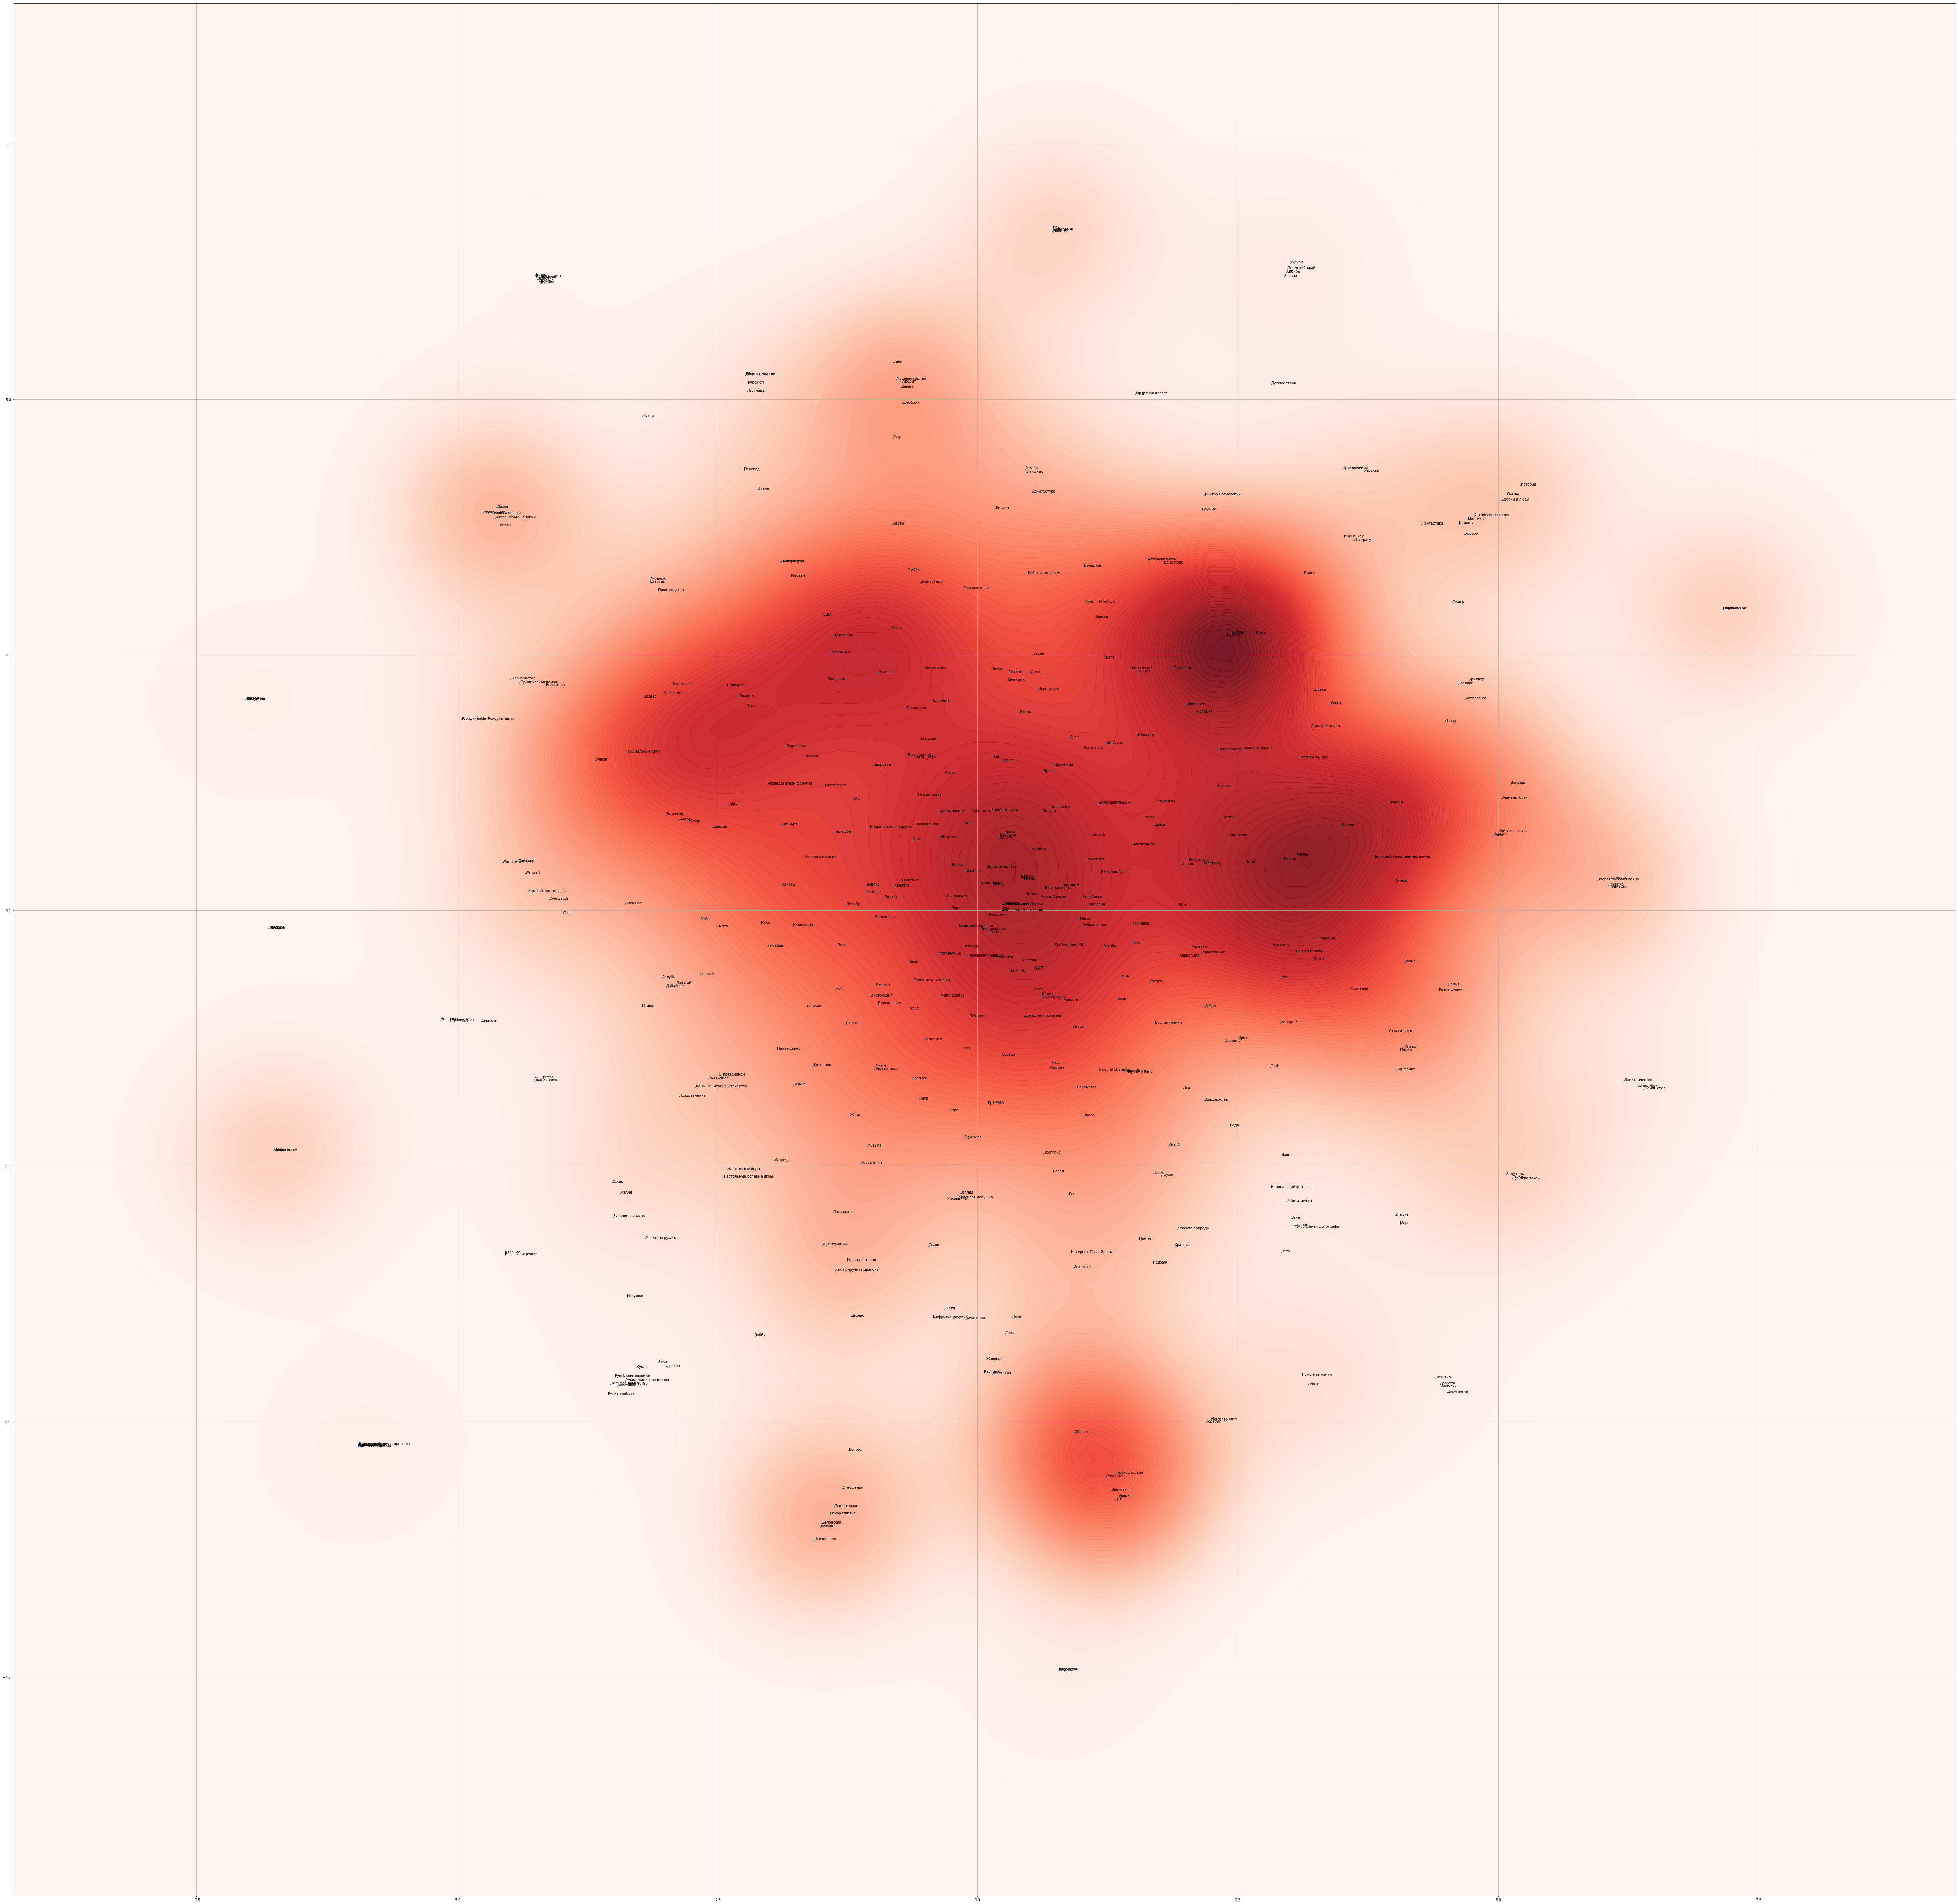

In [390]:
plt.figure(figsize=(100, 100))

sns.kdeplot(svd_tags_matrix.T[0][disliked_indices], svd_tags_matrix.T[1][disliked_indices], alpha=0.9, shade=True, cmap="Reds", n_levels=100)

plt.scatter(svd_tags_matrix.T[0], svd_tags_matrix.T[1], s=5)

plt.grid()

for tag in list(tags):
    tag_index = tags[tag]
    x, y = svd_tags_matrix[tag_index]
    plt.text(x, y, tag, fontdict={"size": 10})